# Titanic survival classification

In [167]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy import interp

## Loading data & Preliminary analysis

### Handling irrelevant variables and missing values

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
datasets = [df_train,df_test]
df0 = df_train

In [4]:
for df in datasets :
    print(df.count(),'\n') #count the number on non NaN rows

#There are missing values in the Age, Cabin, Fare and Embarked columns

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64 

PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64 



The Cabin variable has too many missing values so we choose to delete it.

In [5]:
for df in datasets :
    display(df.describe(include='all'))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Panula, Mrs. Juha (Maria Emilia Ojala)",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Lennon, Miss. Mary",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


Not all variables are relevant to predict survival so we delete the variables that are obviously useless, such as 'PassengerId', 'Name', 'Cabin' and 'Ticket number'.
We use the age and fare median and the port of embarkation mode to replace the missing values.

In [6]:
for df in datasets :
    dropCol = ['PassengerId','Name','Ticket', 'Cabin']
    df.drop(dropCol, axis=1, inplace = True)
    
    df['Age'].fillna(df['Age'].median(), inplace = True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    df['Fare'].fillna(df['Fare'].median(), inplace = True)

    print(df.count())
    display(df.head())

Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch       891
Fare        891
Embarked    891
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Pclass      418
Sex         418
Age         418
SibSp       418
Parch       418
Fare        418
Embarked    418
dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [7]:
scaler = StandardScaler()
for df in datasets :
    df[['Age','SibSp', 'Parch', 'Fare']] = scaler.fit_transform(df[['Age','SibSp', 'Parch', 'Fare']])
    display(df)

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,-0.565736,0.432793,-0.473674,-0.502445,S
1,1,1,female,0.663861,0.432793,-0.473674,0.786845,C
2,1,3,female,-0.258337,-0.474545,-0.473674,-0.488854,S
3,1,1,female,0.433312,0.432793,-0.473674,0.420730,S
4,0,3,male,0.433312,-0.474545,-0.473674,-0.486337,S
5,0,3,male,-0.104637,-0.474545,-0.473674,-0.478116,Q
6,0,1,male,1.893459,-0.474545,-0.473674,0.395814,S
7,0,3,male,-2.102733,2.247470,0.767630,-0.224083,S
8,1,3,female,-0.181487,-0.474545,2.008933,-0.424256,S
9,1,2,female,-1.180535,0.432793,-0.473674,-0.042956,C


C:\Users\pc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\pc\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,0.386231,-0.499470,-0.400248,-0.497413,Q
1,3,female,1.371370,0.616992,-0.400248,-0.512278,S
2,2,male,2.553537,-0.499470,-0.400248,-0.464100,Q
3,3,male,-0.204852,-0.499470,-0.400248,-0.482475,S
4,3,female,-0.598908,0.616992,0.619896,-0.417492,S
5,3,male,-1.229397,-0.499470,-0.400248,-0.472391,S
6,3,female,0.031581,-0.499470,-0.400248,-0.500999,Q
7,2,male,-0.283663,0.616992,0.619896,-0.117894,S
8,3,female,-0.914152,-0.499470,-0.400248,-0.508169,C
9,3,male,-0.677719,1.733455,-0.400248,-0.204838,S


### OneHot Encoding

OneHot encoding of the 'Sex' and 'Embarked' variables.
The categorical variable Pclass is already encoded.

In [8]:
i=0
for df in datasets :
    dfDummiesSex = pd.get_dummies(df['Sex'], prefix = 'Sex')
    dfDummiesPort = pd.get_dummies(df['Embarked'], prefix = 'Port')
    dfDummies = pd.concat([dfDummiesSex, dfDummiesPort], axis=1)

    df = pd.concat([df, dfDummies],axis=1)
    df.drop(['Sex','Embarked'], axis=1, inplace = True)
    display(df.head())
    datasets[i] = df
    i+=1

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
0,0,3,-0.565736,0.432793,-0.473674,-0.502445,0,1,0,0,1
1,1,1,0.663861,0.432793,-0.473674,0.786845,1,0,1,0,0
2,1,3,-0.258337,-0.474545,-0.473674,-0.488854,1,0,0,0,1
3,1,1,0.433312,0.432793,-0.473674,0.420730,1,0,0,0,1
4,0,3,0.433312,-0.474545,-0.473674,-0.486337,0,1,0,0,1


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
0,3,0.386231,-0.499470,-0.400248,-0.497413,0,1,0,1,0
1,3,1.371370,0.616992,-0.400248,-0.512278,1,0,0,0,1
2,2,2.553537,-0.499470,-0.400248,-0.464100,0,1,0,1,0
3,3,-0.204852,-0.499470,-0.400248,-0.482475,0,1,0,0,1
4,3,-0.598908,0.616992,0.619896,-0.417492,1,0,0,0,1


## Exploratory and Descriptive Analysis

In [9]:
df_train = datasets[0]
df_test = datasets[1]

### Correlation Table

In [10]:
df_train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
Survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.149683
Pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.243292,0.221009,0.074053
Age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,-0.081163,0.081163,0.030248,-0.031415,-0.006729
SibSp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.059528,-0.026354,0.068734
Parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,0.245489,-0.245489,-0.011069,-0.081228,0.060814
Fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,0.182333,-0.182333,0.269335,-0.117216,-0.162184
Sex_female,0.543351,-0.131900,-0.081163,0.114631,0.245489,0.182333,1.000000,-1.000000,0.082853,0.074115,-0.119224
Sex_male,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.082853,-0.074115,0.119224
Port_C,0.168240,-0.243292,0.030248,-0.059528,-0.011069,0.269335,0.082853,-0.082853,1.000000,-0.148258,-0.782742
Port_Q,0.003650,0.221009,-0.031415,-0.026354,-0.081228,-0.117216,0.074115,-0.074115,-0.148258,1.000000,-0.499421


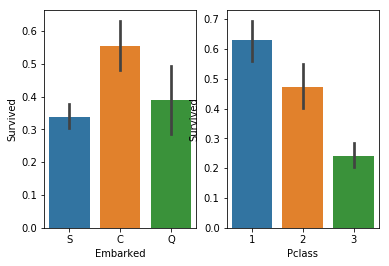

In [11]:
fig, axis = plt.subplots(1, 2)
sns.barplot('Embarked','Survived', data=df0, ax = axis[0])
sns.barplot('Pclass','Survived', data=df_train, ax = axis[1])

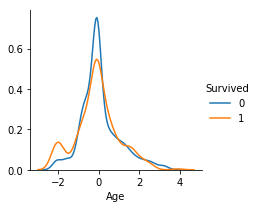

In [12]:
ageplot = sns.FacetGrid(df_train, hue = 'Survived' )
ageplot.map(sns.kdeplot, 'Age')
ageplot.add_legend()

In [13]:
df_train.iloc[:,[0,6,7]].groupby(['Survived']).mean()

,Sex_female,Sex_male
Survived,,
0,0.147541,0.852459
1,0.681287,0.318713


The lower the class, the lower the chance of survival, the lower the age and the lower the fare.

The higher the fare, the higher the chance of survival and the higher the number of family members.

The higher the age, the higher the number of family members.

Passengers in their mid to late 20s were more likely to survive.

Women were more likely to survive. Men were less likely to survive.

# Modeling

Now that we've gone through the descriptive analysis of the data, let's find the best algorithm to model Survival.

In [77]:
data_x = df_train.iloc[:,1:]
data_y = df_train.iloc[:,0]
print(data_x.shape)
print(data_y.shape)

(891, 10)
(891,)


In [179]:
#Data splitting into training and test sets. We make sure that both sets have about the same variable distribution.
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=555)
print(X_train.shape)
print(X_test.shape)

display(y_train.describe())
display(y_test.describe())
display(X_train.describe())
display(X_test.describe())

(668, 10)
(223, 10)


count    668.000000
mean       0.398204
std        0.489895
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

count    223.000000
mean       0.340807
std        0.475047
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,2.267964,0.019803,0.009006,0.015043,0.033705,0.357784,0.642216,0.187126,0.085329,0.727545
std,0.854510,1.020391,0.997581,1.000660,1.064292,0.479707,0.479707,0.390305,0.279581,0.445556
min,1.000000,-2.224156,-0.474545,-0.473674,-0.648422,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,-0.488887,-0.474545,-0.473674,-0.488854,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,-0.104637,-0.474545,-0.473674,-0.331384,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,0.510161,0.432793,-0.473674,-0.016444,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,3.891554,6.784163,6.974147,9.667167,1.000000,1.000000,1.000000,1.000000,1.000000


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,2.430493,-0.059320,-0.026979,-0.045062,-0.100965,0.336323,0.663677,0.192825,0.089686,0.717489
std,0.767213,0.938358,1.011213,1.001161,0.772400,0.473514,0.473514,0.395404,0.286374,0.451234
min,1.000000,-2.179583,-0.474545,-0.473674,-0.648422,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,-0.642586,-0.474545,-0.473674,-0.489442,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,-0.104637,-0.474545,-0.473674,-0.401268,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,0.279612,0.432793,-0.473674,-0.109315,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,3.199906,6.784163,5.732844,4.634417,1.000000,1.000000,1.000000,1.000000,1.000000


We train the different models with cross-validation and then test their prediction accuracy on the test set

In [180]:
modelnames = [
    "Logistic Regression",
    "Linear SVC",
    "SVC",
    "Ridge Classifier",
    "Decision Tree Classifier",
    "Gradient Boosting Classifier",
    "K Neighbors Classifier",
    "Random Forest Classifier"
]

models = [
    LogisticRegression(solver='lbfgs'),
    LinearSVC(max_iter=10000),
    SVC(probability=True, gamma = 'auto'),
    RidgeClassifier(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=100)
]

#comparison table of models performance
table_cols = ['Model', 'Training mean accuracy', 'Validation mean accuracy', 'Testing accuracy']
df_table = pd.DataFrame(columns = table_cols)

#predictions table of the test set
pred_table = pd.DataFrame(y_test, columns = ['Survived'])
pred_table = pred_table.reset_index(drop=True)

i = 0
for model in models:
    df_table.loc[i, 'Model'] = modelnames[i]
    print(modelnames[i])
    
    #Cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    
    #Predictions on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Populating the tables
    df_table.loc[i, 'Training mean accuracy'] = cv_results['train_score'].mean()
    df_table.loc[i, 'Validation mean accuracy'] = cv_results['test_score'].mean()   
    df_table.loc[i, 'Testing accuracy'] = accuracy_score(y_test, y_pred)
    
    pred_table = pd.concat([pred_table, pd.DataFrame(y_pred, columns = [modelnames[i]])], axis=1)
    
    i+=1

df_table.sort_values(by = ['Testing accuracy', 'Validation mean accuracy'], ascending = False, inplace = True)
display(df_table)
display(pred_table.tail())

Logistic Regression
Linear SVC
SVC
Ridge Classifier
Decision Tree Classifier
Gradient Boosting Classifier
K Neighbors Classifier
Random Forest Classifier


,Model,Training mean accuracy,Validation mean accuracy,Testing accuracy
2,SVC,0.815533,0.80824,0.887892
6,K Neighbors Classifier,0.842815,0.786027,0.860987
1,Linear SVC,0.783099,0.770967,0.847534
3,Ridge Classifier,0.782434,0.769451,0.847534
0,Logistic Regression,0.788922,0.775468,0.834081
5,Gradient Boosting Classifier,0.899868,0.817285,0.829596
7,Random Forest Classifier,0.983199,0.79632,0.829596
4,Decision Tree Classifier,0.983199,0.773747,0.789238


,Survived,Logistic Regression,Linear SVC,SVC,Ridge Classifier,Decision Tree Classifier,Gradient Boosting Classifier,K Neighbors Classifier,Random Forest Classifier
218,1,1,1,1,1,1,1,1,1
219,1,1,1,1,1,0,1,1,0
220,1,0,0,0,0,1,0,0,1
221,0,0,0,0,0,0,0,0,0
222,0,0,0,0,0,0,0,0,0


#### ROC curve visualization

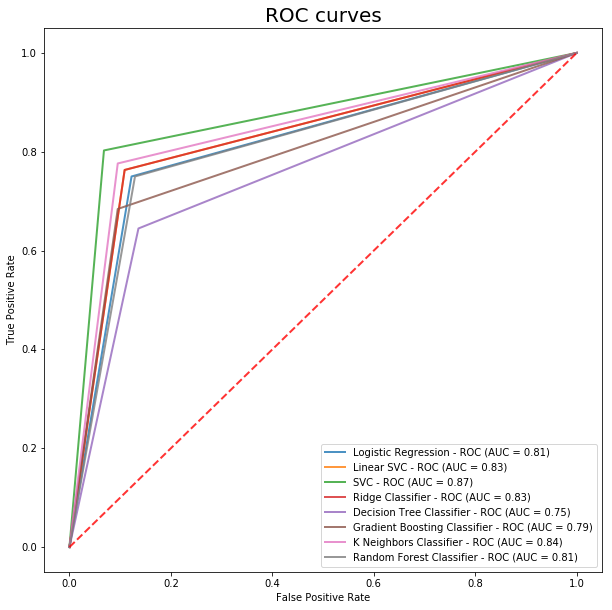

In [183]:
y_true = pred_table['Survived']
plt.figure(figsize=(10,10))

for i in range(1,len(pred_table.columns)):
    modelName = pred_table.columns[i]
    model = models[i-1]
    
    y_pred = pred_table[modelName]

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr,
             label=r'%s - ROC (AUC = %0.2f)' % (modelName,roc_auc),
             lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves', fontsize=20)
plt.legend(loc="lower right")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)   
#plt.savefig('ROC_curves', fontsize=20)
plt.show()

In [185]:
print("Confusion Matrix:")
print(confusion_matrix(pred_table['Survived'],pred_table['SVC']))

print("\nClassification Report:")
print(classification_report(pred_table['Survived'],pred_table['SVC']))

Confusion Matrix:
[[137  10]
 [ 15  61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       147
           1       0.86      0.80      0.83        76

   micro avg       0.89      0.89      0.89       223
   macro avg       0.88      0.87      0.87       223
weighted avg       0.89      0.89      0.89       223



In [ ]:
The Support Vector Machine Classification appears to have the best default performance and makes the most accurate predictions. We avoided overfitting and reached a very performant model without any tuning. But let's see if Feature Selection 